<a href="https://colab.research.google.com/github/SanskritiBelwal/AI-ML-Case-Studies/blob/main/Biopython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
pip install biopython

In [46]:
!apt-get update
!apt-get install clustalo -y

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [47]:
# Libraries used in the Biopython Pipeline
import json
import requests
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import Entrez
from Bio.Seq import Seq
from Bio import pairwise2
from matplotlib import cm
import matplotlib.pyplot as plt
from collections import Counter
from Bio.Align import AlignInfo
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import gc_fraction
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.SeqUtils import molecular_weight
from Bio.pairwise2 import format_alignment
from Bio.Align import MultipleSeqAlignment
from Bio.Align import substitution_matrices
from Bio import SeqIO, pairwise2, AlignIO, Phylo
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
# Data handling
try:
    import pandas as pd
except ImportError:
    pd = None  # Fallback if pandas is not installed
# Visualization
import matplotlib.pyplot as plt
# System utilities
import os
import sys

In [16]:
def parse_fasta(fasta_path: str):
    if not os.path.exists(fasta_path):
        raise FileNotFoundError(f"File not found: {fasta_path}")
    # Parse the FASTA file
    records = list(SeqIO.parse(fasta_path, "fasta"))
    print(f"Parsed {len(records)} sequences from {fasta_path}")
    return records
fasta_file = "/content/drive/MyDrive/DATASET/sequence homo sapiens.fasta"
records = parse_fasta(fasta_file)
# Inspect the first sequence
print(f"ID: {records[0].id}")
print(f"Description: {records[0].description}")
print(f"Sequence (first 50 bases): {records[0].seq[:50]}")

Parsed 2 sequences from /content/drive/MyDrive/DATASET/sequence homo sapiens.fasta
ID: NM_001256799.3
Description: NM_001256799.3 Homo sapiens glyceraldehyde-3-phosphate dehydrogenase (GAPDH), transcript variant 2, mRNA
Sequence (first 50 bases): GTCCGGATGCTGCGCCTGCGGTAGAGCGGCCGCCATGTTGCAACCGGGAA


In [17]:
def infer_sequence_type(seq: Seq, user_type: str = None):
    #Infer sequence type (DNA, RNA, Protein) or use user-specified type.
    if user_type:
        return user_type.upper()
    s = str(seq).upper()
    dna_bases = set("ATGCN")
    rna_bases = set("AUGCN")

    if set(s) <= dna_bases:
        return "DNA"
    elif set(s) <= rna_bases:
        return "RNA"
    else:
        return "Protein"
def basic_sequence_info(record: SeqRecord, seq_type: str = None):
    #Compute basic sequence information: length, base/residue counts, GC content, Tm approximation, molecular weight.
    seq = record.seq
    seq_type = infer_sequence_type(seq, seq_type)
    info = {}
    info['ID'] = record.id
    info['Description'] = record.description
    info['Length'] = len(seq)
    info['Type'] = seq_type
    if seq_type in ['DNA', 'RNA']:
        # Counts
        seq_str = str(seq).upper()
        counts = Counter(seq_str)
        info['Counts'] = counts
        # Percentage composition
        info['Percentage'] = {k: (v/len(seq_str))*100 for k,v in counts.items()}
        # GC content
        gc = gc_fraction(seq) * 100  # Biopython returns fraction
        info['GC%'] = gc
        # Approximate melting temperature (Wallace rule)
        at = counts.get('A',0) + counts.get('T',0) + counts.get('U',0)
        gc_count = counts.get('G',0) + counts.get('C',0)
        info['Tm_approx'] = 2*at + 4*gc_count
        # Molecular weight (approximate)
        info['MolecularWeight'] = molecular_weight(seq, seq_type='DNA' if seq_type=='DNA' else 'RNA')
    elif seq_type == 'PROTEIN':
        prot_seq = str(seq)
        analysis = ProteinAnalysis(prot_seq)
        info['AminoAcidCounts'] = analysis.count_amino_acids()
        info['Percentage'] = analysis.get_amino_acids_percent()
        info['MolecularWeight'] = analysis.molecular_weight()
        info['IsoelectricPoint'] = analysis.isoelectric_point()
    return info
def reverse_complement(seq: Seq):
    #Return reverse complement of DNA/RNA sequence.
    return seq.reverse_complement()
def transcribe_dna(seq: Seq):
    #Transcribe DNA to RNA.
    return seq.transcribe()
def translate_seq(seq: Seq, to_stop: bool = True):
    #Translate DNA/RNA to protein sequence.
    return seq.translate(to_stop=to_stop)
def codon_usage(seq: Seq):
    #Compute codon usage frequency for a DNA sequence.
    #Returns a dictionary {codon: count}.
    seq_str = str(seq).upper()
    codons = [seq_str[i:i+3] for i in range(0, len(seq_str)-2, 3)]
    return dict(Counter(codons))
def find_orfs(seq: Seq, min_len: int = 50):
   #Find ORFs in all 3 forward frames (basic).
   #Returns list of tuples: (start, end, ORF sequence)
    seq_str = str(seq).upper()
    START = 'ATG'
    STOP = {'TAA', 'TAG', 'TGA'}
    orfs = []
    for frame in range(3):
        i = frame
        while i < len(seq_str)-2:
            codon = seq_str[i:i+3]
            if codon == START:
                for j in range(i+3, len(seq_str)-2, 3):
                    stop_codon = seq_str[j:j+3]
                    if stop_codon in STOP:
                        orf_len = j+3-i
                        if orf_len >= min_len*3:
                            orfs.append((i, j+3, seq[i:j+3]))
                        i = j+3
                        break
                else:
                    i +=3
            else:
                i +=3
    return orfs
def motif_search(seq: Seq, motif: str):
    #Search for all occurrences of a motif/subsequence.
    #Returns list of start positions (0-based).
    seq_str = str(seq).upper()
    motif = motif.upper()
    positions = []
    pos = seq_str.find(motif)
    while pos != -1:
        positions.append(pos)
        pos = seq_str.find(motif, pos+1)
    return positions
for record in records:
    print(f"\n=== Sequence: {record.id} ===")
for record in records:
    info = basic_sequence_info(record)
    print(f"\nSequence {info['ID']} ({info['Type']}, length {info['Length']}):")
    print("Counts:", info['Counts'])
    print("GC%:", info.get('GC%'))
    print("Tm approx:", info.get('Tm_approx'))
    print("Molecular weight:", info.get('MolecularWeight'))
    if info['Type'] in ['DNA', 'RNA']:
        rc = reverse_complement(record.seq)
        rna = transcribe_dna(record.seq)
        protein = translate_seq(record.seq)
        codon_freq = codon_usage(record.seq)
        orfs = find_orfs(record.seq)
        print(f"Reverse complement (first 50 bases): {rc[:50]}")
        print(f"Transcribed RNA (first 50 bases): {rna[:50]}")
        print(f"Translated protein (first 50 aa): {protein[:50]}")
        print(f"Codon usage (first 5 codons): {list(codon_freq.items())[:5]}")
        print(f"Found {len(orfs)} ORFs (show first 3): {[o[2] for o in orfs[:3]]}")


=== Sequence: NM_001256799.3 ===

=== Sequence: dummy_seq ===

Sequence NM_001256799.3 (DNA, length 1386):
Counts: Counter({'C': 412, 'G': 372, 'A': 311, 'T': 291})
GC%: 56.56565656565656
Tm approx: 4340
Molecular weight: 427552.9544
Reverse complement (first 50 bases): TGGTTGAGCACAGGGTACTTTATTGATGGTACATGACAAGGTGCGGCTCC
Transcribed RNA (first 50 bases): GUCCGGAUGCUGCGCCUGCGGUAGAGCGGCCGCCAUGUUGCAACCGGGAA
Translated protein (first 50 aa): VRMLRLR
Codon usage (first 5 codons): [('GTC', 16), ('CGG', 2), ('ATG', 12), ('CTG', 11), ('CGC', 5)]
Found 3 ORFs (show first 3): [Seq('ATGGTTTACATGTTCCAATATGATTCCACCCATGGCAAATTCCATGGCACCGTC...TAA'), Seq('ATGACCCCTTCATTGACCTCAACTACATGGTTTACATGTTCCAATATGATTCCA...TGA'), Seq('ATGACAACGAATTTGGCTACAGCAACAGGGTGGTGGACCTCATGGCCCACATGG...TGA')]

Sequence dummy_seq (DNA, length 1386):
Counts: Counter({'T': 602, 'C': 412, 'G': 372})
GC%: 56.56565656565656
Tm approx: 4340
Molecular weight: 424749.8181
Reverse complement (first 50 bases): AGGAAGAGCACAGGGAACAAAAAAG

In [18]:
START_CODON = "ATG"
STOP_CODONS = {"TAA", "TAG", "TGA"}
def transcribe_dna(seq: Seq, strand: str = "+") -> Seq:
    #Transcribe DNA to RNA.
    if strand == "-":
        seq = seq.reverse_complement()
    return seq.transcribe()
def translate_dna(seq: Seq, frame: int = 0, to_stop: bool = True) -> Seq:
    #Translate DNA sequence to protein sequence in a given frame.
    return seq[frame:].translate(to_stop=to_stop)
def six_frame_translation(seq: Seq, to_stop: bool = True) -> dict:
   # Translate a DNA sequence in all six reading frames.
    translations = {}
    # Forward frames
    for frame in range(3):
        translations[f"+{frame+1}"] = translate_dna(seq, frame, to_stop)
    # Reverse frames
    rc_seq = seq.reverse_complement()
    for frame in range(3):
        translations[f"-{frame+1}"] = translate_dna(rc_seq, frame, to_stop)
    return translations
def find_orfs(seq: Seq, min_aa_len: int = 50) -> dict:
    #Detect all ORFs in six frames (forward + reverse) with minimum amino acid length.
    orfs = {}
    # Forward frames
    for frame in range(3):
        frame_label = f"+{frame+1}"
        orfs[frame_label] = []
        i = frame
        seq_str = str(seq).upper()
        while i < len(seq_str) - 2:
            codon = seq_str[i:i+3]
            if codon == START_CODON:
                for j in range(i+3, len(seq_str)-2, 3):
                    if seq_str[j:j+3] in STOP_CODONS:
                        orf_len = j+3-i
                        if orf_len//3 >= min_aa_len:
                            orfs[frame_label].append((i, j+3, seq[i:j+3]))
                        i = j + 3
                        break
                else:
                    i += 3
            else:
                i += 3
    # Reverse frames
    rc_seq = seq.reverse_complement()
    rc_str = str(rc_seq).upper()
    for frame in range(3):
        frame_label = f"-{frame+1}"
        orfs[frame_label] = []
        i = frame
        while i < len(rc_str) - 2:
            codon = rc_str[i:i+3]
            if codon == START_CODON:
                for j in range(i+3, len(rc_str)-2, 3):
                    if rc_str[j:j+3] in STOP_CODONS:
                        orf_len = j+3-i
                        if orf_len//3 >= min_aa_len:
                            orfs[frame_label].append((i, j+3, rc_seq[i:j+3]))
                        i = j + 3
                        break
                else:
                    i += 3
            else:
                i += 3
    return orfs
def codon_usage(seq: Seq) -> dict:
    #Count frequency of each codon in the DNA sequence.
    seq_str = str(seq).upper()
    codons = [seq_str[i:i+3] for i in range(0, len(seq_str)-2, 3)]
    return dict(Counter(codons))
def analyze_protein(protein_seq: Seq) -> dict:
    #Compute basic protein features using Biopython ProteinAnalysis.
    prot = ProteinAnalysis(str(protein_seq))
    return {
        "Length": len(protein_seq),
        "AminoAcidCounts": prot.count_amino_acids(),
        "PercentageComposition": prot.get_amino_acids_percent(),
        "MolecularWeight": prot.molecular_weight(),
        "IsoelectricPoint": prot.isoelectric_point()
    }
for record in records:
    print(f"\n=== Sequence: {record.id} ===")
    # Six-frame translation
    translations = six_frame_translation(record.seq)
    for frame, prot_seq in translations.items():
        print(f"Frame {frame} protein length: {len(prot_seq)}")
    # ORFs
    orfs = find_orfs(record.seq, min_aa_len=50)
    total_orfs = sum(len(lst) for lst in orfs.values())
    print(f"Total ORFs found: {total_orfs}")
    # Codon usage
    codon_freq = codon_usage(record.seq)
    print(f"Number of unique codons: {len(codon_freq)} (first 5: {list(codon_freq.items())[:5]})")
    # Analyze first ORF if exists
    first_orf = None
    for frame_list in orfs.values():
        if frame_list:
            first_orf = frame_list[0][2]  # DNA sequence of ORF
            break
    if first_orf:
        prot_seq = translate_dna(first_orf)
        prot_features = analyze_protein(prot_seq)
        print(f"First ORF translated protein length: {prot_features['Length']}")
        print(f"Amino acid composition (first 5): {dict(list(prot_features['AminoAcidCounts'].items())[:5])}")
        print(f"Molecular weight: {prot_features['MolecularWeight']:.2f} Da, pI: {prot_features['IsoelectricPoint']:.2f}")


=== Sequence: NM_001256799.3 ===
Frame +1 protein length: 7
Frame +2 protein length: 18
Frame +3 protein length: 28
Frame -1 protein length: 11
Frame -2 protein length: 1
Frame -3 protein length: 7
Total ORFs found: 7
Number of unique codons: 62 (first 5: [('GTC', 16), ('CGG', 2), ('ATG', 12), ('CTG', 11), ('CGC', 5)])
First ORF translated protein length: 293
Amino acid composition (first 5): {'A': 28, 'C': 3, 'D': 17, 'E': 13, 'F': 11}
Molecular weight: 31547.58 Da, pI: 7.15

=== Sequence: dummy_seq ===
Frame +1 protein length: 462
Frame +2 protein length: 461
Frame +3 protein length: 461
Frame -1 protein length: 462
Frame -2 protein length: 461
Frame -3 protein length: 461
Total ORFs found: 0
Number of unique codons: 27 (first 5: [('GTC', 30), ('CGG', 2), ('TTG', 37), ('CTG', 20), ('CGC', 5)])


/usr/local/lib/python3.12/dist-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


In [19]:
# Input / Output Paths
fasta_file = "/content/drive/MyDrive/DATASET/sequence homo sapiens.fasta"
msa_output = "/content/drive/MyDrive/aligned_sequences.fasta"
# Parse sequences
records = list(SeqIO.parse(fasta_file, "fasta"))
num_seq = len(records)
print(f"Number of sequences in FASTA: {num_seq}")
# Add a second sequence if needed
if num_seq < 2:
    dummy_seq = SeqRecord(
        Seq(str(records[0].seq).replace("A","T")),
        id="dummy_seq",
        description="Artificial second sequence"
    )
    records.append(dummy_seq)
    num_seq += 1
    # Save updated FASTA back
    SeqIO.write(records, fasta_file, "fasta")
    print("Added a second sequence to enable alignment.")
# Pairwise alignment (first 2 sequences)
seq1 = records[0].seq
seq2 = records[1].seq
global_align = pairwise2.align.globalxx(seq1, seq2)
local_align = pairwise2.align.localxx(seq1, seq2)
print("\n=== Global Pairwise Alignment ===")
print(pairwise2.format_alignment(*global_align[0]))
print("\n=== Local Pairwise Alignment ===")
print(pairwise2.format_alignment(*local_align[0]))
# Multiple Sequence Alignment (MSA) with Clustal Omega
clustalomega_cline = ClustalOmegaCommandline(
    infile=fasta_file,
    outfile=msa_output,
    verbose=True,
    auto=True,
    force=True
)
# Run Clustal Omega
result = subprocess.run(str(clustalomega_cline), shell=True, capture_output=True, text=True)
if result.returncode != 0:
    print("Error running Clustal Omega:\n", result.stderr)
else:
    alignment = AlignIO.read(msa_output, "fasta")
    print(f"\n=== MSA loaded successfully ({len(alignment)} sequences) ===\n")
    for record in alignment:
        print(f">{record.id}\n{record.seq}\n")
    # Phylogenetic tree
    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(alignment)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(dm)
    print("\n=== Phylogenetic Tree (ASCII) ===")
    Phylo.draw_ascii(tree)
# Homology search using BLAST
def blast_sequence(seq_record):
    print(f"\n=== BLAST Search for: {seq_record.id} ===")
    result_handle = NCBIWWW.qblast("blastn", "nt", seq_record.seq)
    blast_record = NCBIXML.read(result_handle)
    print("Top 3 BLAST hits:")
    for alignment in blast_record.alignments[:3]:
        for hsp in alignment.hsps[:1]:
            print(f"Hit: {alignment.title}")
            print(f"Score: {hsp.score}, E-value: {hsp.expect}")
    print("-"*50)
# Run BLAST on the first sequence
blast_sequence(records[0])
def run_interpro_annotation(seq_record: SeqRecord):
    #Query InterProScan REST API to fetch domains/motifs for a protein/DNA sequence.
    print(f"\n=== Functional Annotation for: {seq_record.id} ===")
    # InterProScan REST API endpoint for sequence analysis
    url = "https://www.ebi.ac.uk/interpro/api/protein/entry/sequence/"
    headers = {
        "Content-Type": "text/plain",
        "Accept": "application/json"
    }
    # Submit the sequence (convert to string)
    response = requests.post(url, headers=headers, data=str(seq_record.seq))
    if response.status_code == 200:
        results = response.json()
        if len(results) == 0:
            print("No domains or motifs detected for this sequence.")
        else:
            print(f"Found {len(results)} functional features:")
            for feature in results[:5]:  # show first 5 features for brevity
                print(f"- {feature.get('entry', {}).get('name', 'Unknown')} | Type: {feature.get('entry', {}).get('type', 'Unknown')} | Start: {feature.get('start', '?')} | End: {feature.get('end', '?')}")
    else:
        print("Error querying InterProScan API:", response.status_code)
        print(response.text)


Number of sequences in FASTA: 2

=== Global Pairwise Alignment ===
GTCCGGAT-GCTGCGCCTGCGGTA-GA-GCGGCCGCCAT-GTTGCAA--CCGGGAA--GGAAAT---GAAT--GGGCA-GCCGTTA-GGAAA---GCCTGCCGGTGA-CTAA--CCCTGCGCTCCTGCCTCGAT-GGGTGGA-GTCGCGTGTGGCGGGGAA--GTCA-GGTGGA-GCGA-GGCTA-GCTGGCCCGATTT-CTCCTCCGGGTGAT-GCTTTTCCTA-GATTATT--CTCTGATTT-GGTCGTATT-GGGCGCCTGGTCA-CCA-GGGCTGCTTTTAA--CTCTGGTAAA---GTGGATATT--GTTGCCAT-CAAT--GA-CCCCTTCATT-GA-CCTCAA--CTA-CAT-GGTTTA-CAT-GTTCCAATAT---GATT-CCA-CCCAT-GGCAAATT---CCAT-GGCA-CCGTCAA--GGCTGA-GAA--CGGGAA--GCTTGTCAT-CAAT--GGAAAT---CCCAT-CA-CCAT-CTTCCA-GGA-GCGA-GAT-CCCTCCAAAAT----CAA--GTGGGGCGAT-GCTGGCGCTGA-GTA-CGTCGTGGA-GTCCA-CTGGCGTCTTCA-CCA-CCAT-GGA-GAA--GGCTGGGGCTCATTT-GCA-GGGGGGA-GCCAAAA----GGGTCAT-CAT-CTCTGCCCCCTCTGCTGAT-GCCCCCAT-GTTCGTCAT-GGGTGTGAA--CCAT-GA-GAA--GTAT-GA-CAA--CA-GCCTCAA--GAT-CAT-CA-GCAAT--GCCTCCTGCA-CCA-CCAA--CTGCTTA-GCA-CCCCTGGCCAA--GGTCAT-CCAT-GA-CAA--CTTTGGTAT-CGTGGAA--GGA-CTCAT-GA-CCA-CA-GTCCAT-GCCAT-CA-CTGCCA-CCCA-GAA--GA-CTGTGGAT-GGCCCCTCCGGGAAA---CTGTGG

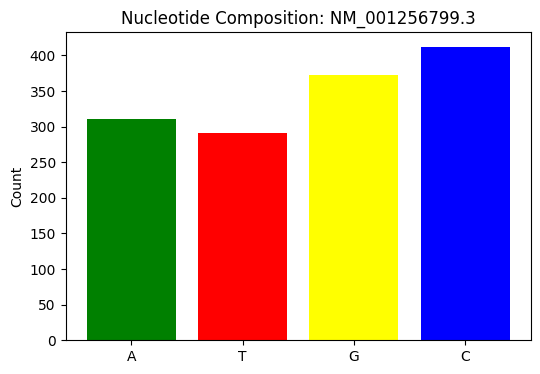

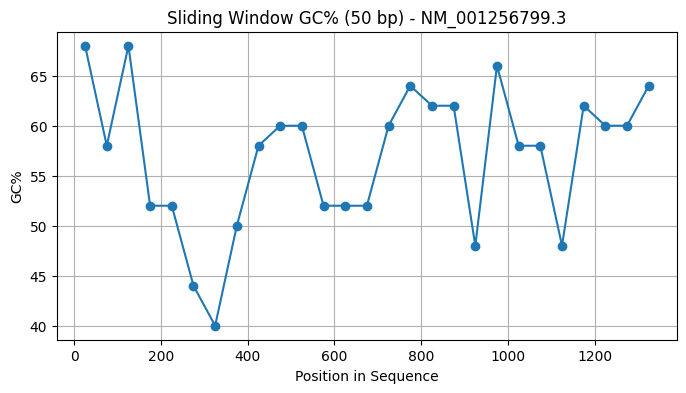

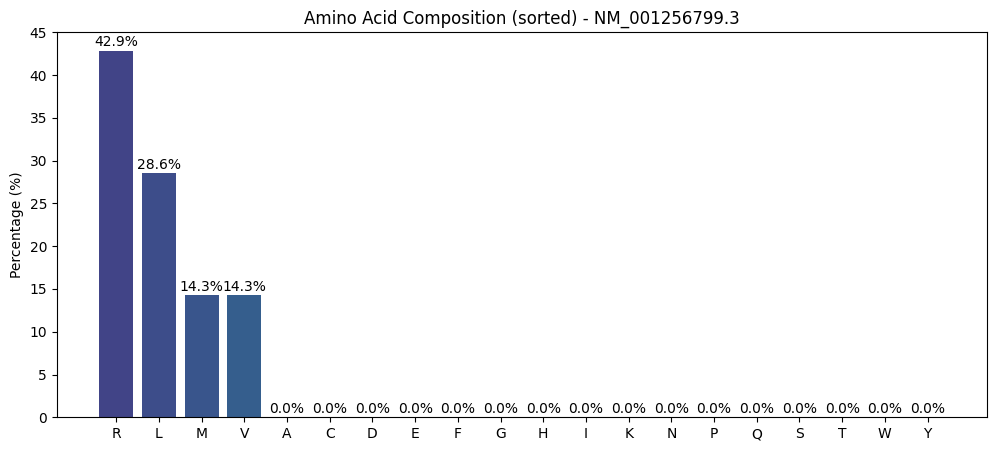

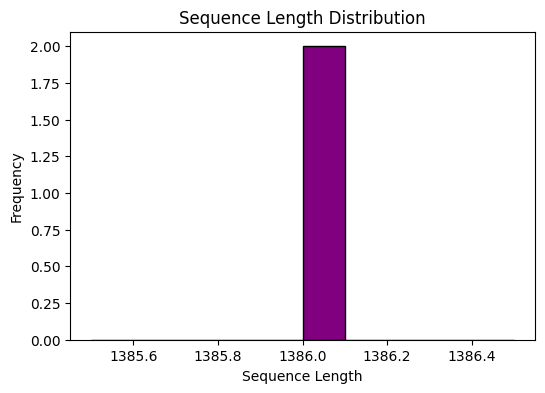

In [20]:
# Nucleotide Composition Plot (for DNA)
def plot_nucleotide_composition(seq_record: SeqRecord):
    seq = seq_record.seq.upper()
    counts = {
        'A': seq.count('A'),
        'T': seq.count('T'),
        'G': seq.count('G'),
        'C': seq.count('C')
    }
    plt.figure(figsize=(6,4))
    plt.bar(counts.keys(), counts.values(), color=['green','red','yellow','blue'])
    plt.title(f"Nucleotide Composition: {seq_record.id}")
    plt.ylabel("Count")
    plt.show()
# GC Content Sliding Window
def plot_gc_content(seq_record: SeqRecord, window=50):
    seq = seq_record.seq.upper()
    gc_values = []
    positions = []
    for i in range(0, len(seq)-window+1, window):
        window_seq = seq[i:i+window]
        gc_percent = gc_fraction(window_seq) * 100  # Use gc_fraction
        gc_values.append(gc_percent)
        positions.append(i + window//2)
    plt.figure(figsize=(8,4))
    plt.plot(positions, gc_values, marker='o')
    plt.title(f"Sliding Window GC% ({window} bp) - {seq_record.id}")
    plt.xlabel("Position in Sequence")
    plt.ylabel("GC%")
    plt.grid(True)
    plt.show()
# Amino Acid Composition
def plot_protein_composition_enhanced(seq_record: SeqRecord):
    seq = str(seq_record.seq)
    analysis = ProteinAnalysis(seq)
    aa_freq = analysis.get_amino_acids_percent()
    # Sort amino acids by frequency
    aa_sorted = sorted(aa_freq.items(), key=lambda x: x[1], reverse=True)
    aa_labels = [x[0] for x in aa_sorted]
    aa_values = [x[1]*100 for x in aa_sorted]  # convert to %
    colors = cm.viridis(np.linspace(0.2, 0.8, len(aa_labels)))
    plt.figure(figsize=(12,5))
    bars = plt.bar(aa_labels, aa_values, color=colors)
    plt.title(f"Amino Acid Composition (sorted) - {seq_record.id}")
    plt.ylabel("Percentage (%)")
    # Add percentage labels on top of bars
    for bar, val in zip(bars, aa_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.5, f"{val:.1f}%", ha='center')
    plt.show()
# Sequence Length Histogram
def plot_sequence_lengths(records):
    lengths = [len(r.seq) for r in records]
    plt.figure(figsize=(6,4))
    plt.hist(lengths, bins=10, color='purple', edgecolor='black')
    plt.title("Sequence Length Distribution")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.show()
# 1. Nucleotide composition
plot_nucleotide_composition(records[0])
# 2. GC content sliding window
plot_gc_content(records[0], window=50)
# Translate DNA to protein for amino acid plot
protein_seq = records[0].seq.translate(to_stop=True)
protein_record = SeqRecord(protein_seq, id=records[0].id)
plot_protein_composition_enhanced(protein_record)
plot_sequence_lengths(records)


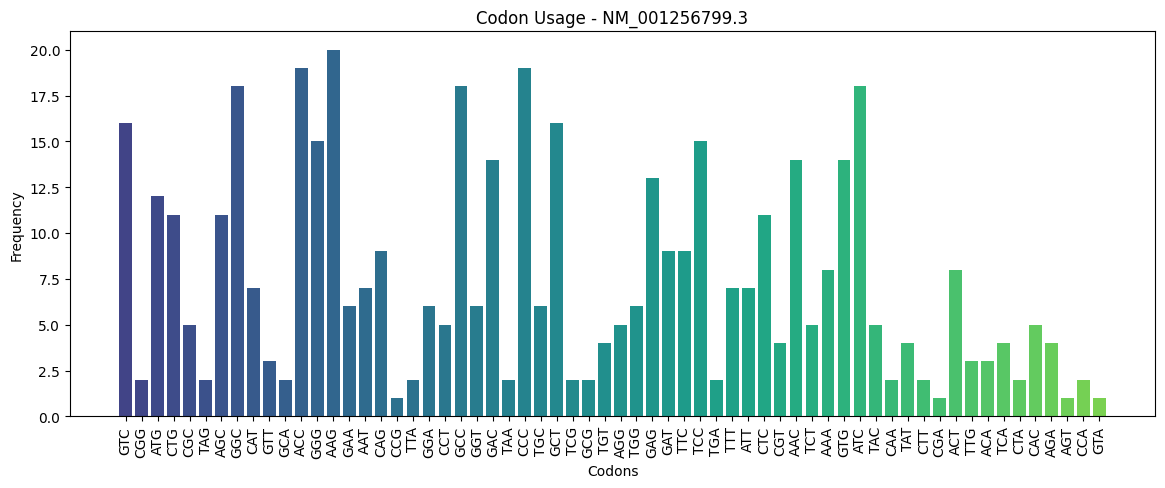

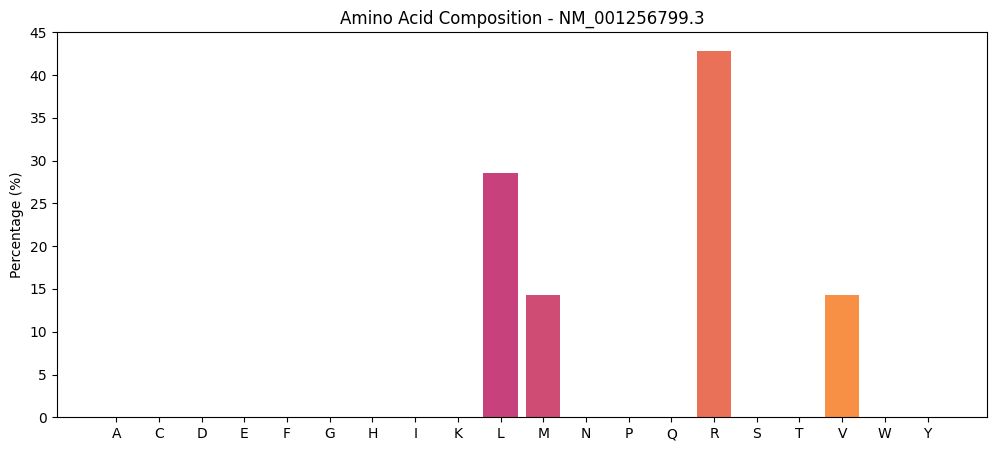

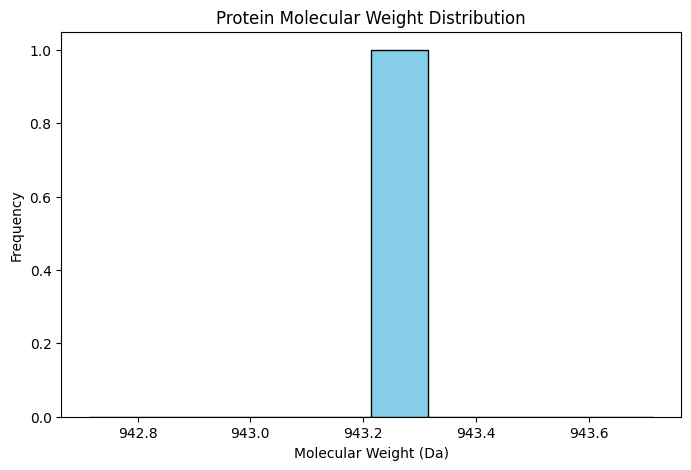

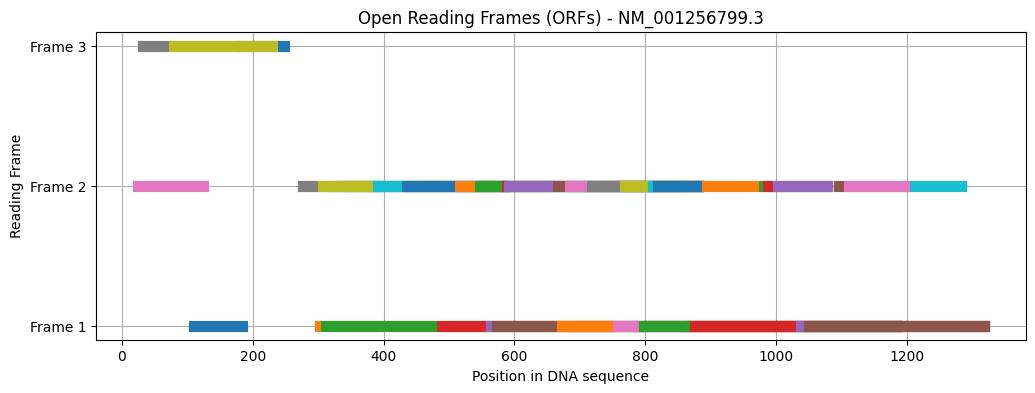

In [21]:
# Codon Usage Plot
def plot_codon_usage(dna_seq: SeqRecord):
    seq = str(dna_seq.seq.upper())
    codons = [seq[i:i+3] for i in range(0, len(seq)-2, 3)]  # triplets
    codon_counts = Counter(codons)
    codon_labels = list(codon_counts.keys())
    codon_freq = list(codon_counts.values())
    plt.figure(figsize=(14,5))
    plt.bar(codon_labels, codon_freq, color=plt.cm.viridis(np.linspace(0.2,0.8,len(codon_labels))))
    plt.xticks(rotation=90)
    plt.xlabel("Codons")
    plt.ylabel("Frequency")
    plt.title(f"Codon Usage - {dna_seq.id}")
    plt.show()
# Amino Acid Composition Plot (Bar Chart)
def plot_amino_acid_composition(protein_seq: SeqRecord):
    seq_str = str(protein_seq.seq)
    analysis = ProteinAnalysis(seq_str)
    aa_freq = analysis.get_amino_acids_percent()
    plt.figure(figsize=(12,5))
    labels = list(aa_freq.keys())
    values = [v*100 for v in aa_freq.values()]  # percentage
    plt.bar(labels, values, color=plt.cm.plasma(np.linspace(0.2,0.8,len(labels))))
    plt.ylabel("Percentage (%)")
    plt.title(f"Amino Acid Composition - {protein_seq.id}")
    plt.show()
# Molecular Weight Distribution
def plot_protein_mw(protein_records: list):
    weights = [molecular_weight(str(r.seq), seq_type='protein') for r in protein_records]
    plt.figure(figsize=(8,5))
    plt.hist(weights, bins=10, color='skyblue', edgecolor='black')
    plt.xlabel("Molecular Weight (Da)")
    plt.ylabel("Frequency")
    plt.title("Protein Molecular Weight Distribution")
    plt.show()
# ORF Visualization
def plot_orfs(dna_seq: SeqRecord, min_orf_len=50):
    seq = str(dna_seq.seq).upper()
    orfs = []
    # Forward strand
    for frame in range(3):
        for i in range(frame, len(seq)-2, 3):
            codon = seq[i:i+3]
            if codon == "ATG":  # start codon
                for j in range(i, len(seq)-2, 3):
                    stop_codon = seq[j:j+3]
                    if stop_codon in ["TAA","TAG","TGA"]:
                        if j-i+3 >= min_orf_len:
                            orfs.append((i, j+3, '+', frame+1))
                        break
    # Reverse strand
    rev_seq = str(dna_seq.seq.reverse_complement()).upper()
    for frame in range(3):
        for i in range(frame, len(rev_seq)-2, 3):
            codon = rev_seq[i:i+3]
            if codon == "ATG":
                for j in range(i, len(rev_seq)-2, 3):
                    stop_codon = rev_seq[j:j+3]
                    if stop_codon in ["TAA","TAG","TGA"]:
                        if j-i+3 >= min_orf_len:
                            orfs.append((i, j+3, '-', frame+1))
                        break
    # Plot ORFs
    plt.figure(figsize=(12,4))
    for start, end, strand, frame in orfs:
        plt.plot([start, end], [frame]*2, lw=8, label=f'Strand {strand}, Frame {frame}')
    plt.title(f"Open Reading Frames (ORFs) - {dna_seq.id}")
    plt.xlabel("Position in DNA sequence")
    plt.ylabel("Reading Frame")
    plt.yticks([1,2,3], ['Frame 1','Frame 2','Frame 3'])
    plt.grid(True)
    plt.show()
# Translate first DNA sequence
protein_seq = SeqRecord(records[0].seq.translate(to_stop=True), id=records[0].id)
# 1. Codon usage
plot_codon_usage(records[0])
# 2. Amino acid composition
plot_amino_acid_composition(protein_seq)
# 3. Molecular weight distribution (example: using list of protein sequences)
protein_records = [protein_seq]  # add more proteins if available
plot_protein_mw(protein_records)
# 4. ORF visualization
plot_orfs(records[0], min_orf_len=50)


/usr/local/lib/python3.12/dist-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


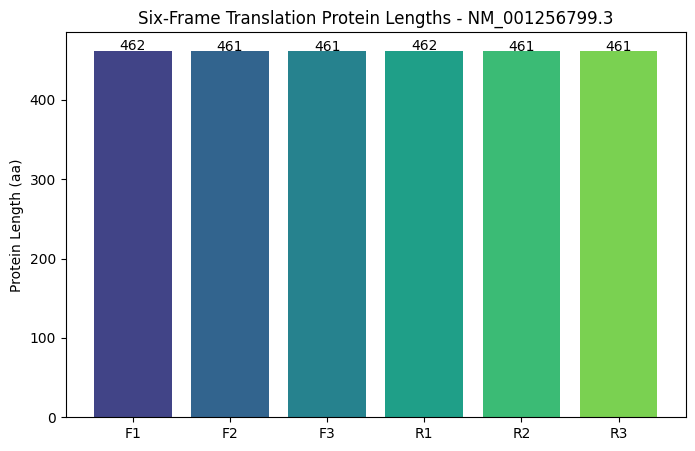

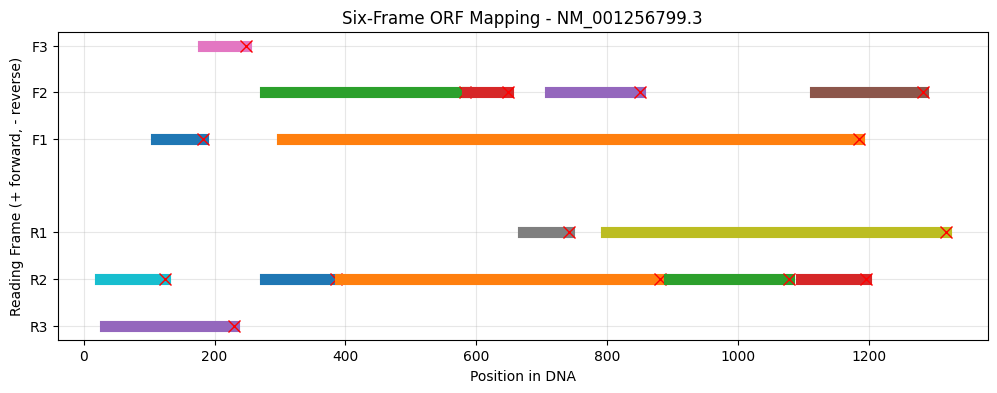

In [22]:
def six_frame_translation_lengths(dna_seq: SeqRecord):
    seq = dna_seq.seq
    frames = []
    # Forward frames
    for frame in range(3):
        protein = seq[frame:].translate(to_stop=False)
        frames.append(protein)
    # Reverse frames
    rev_seq = seq.reverse_complement()
    for frame in range(3):
        protein = rev_seq[frame:].translate(to_stop=False)
        frames.append(protein)
    # Protein lengths
    protein_lengths = [len(p) for p in frames]
    # Plot bar chart
    frame_labels = ['F1','F2','F3','R1','R2','R3']
    plt.figure(figsize=(8,5))
    bars = plt.bar(frame_labels, protein_lengths, color=plt.cm.viridis(np.linspace(0.2,0.8,6)))
    plt.ylabel("Protein Length (aa)")
    plt.title(f"Six-Frame Translation Protein Lengths - {dna_seq.id}")
    # Annotate values
    for bar, length in zip(bars, protein_lengths):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(length), ha='center')
    plt.show()
    return frames
def plot_orfs_six_frames(dna_seq: SeqRecord, min_orf_len=50):
    seq = str(dna_seq.seq).upper()
    orfs = []
    # Helper to find ORFs in a sequence
    def find_orfs(seq_str, strand):
        results = []
        for frame in range(3):
            i = frame
            while i < len(seq_str)-2:
                codon = seq_str[i:i+3]
                if codon == 'ATG':  # start
                    for j in range(i, len(seq_str)-2, 3):
                        stop_codon = seq_str[j:j+3]
                        if stop_codon in ['TAA','TAG','TGA']:
                            if j-i+3 >= min_orf_len:
                                results.append((i, j+3, frame+1, strand))
                            i = j + 3
                            break
                i += 3
        return results
    # Forward strand
    orfs += find_orfs(seq, '+')
    # Reverse strand
    rev_seq = str(dna_seq.seq.reverse_complement()).upper()
    orfs += find_orfs(rev_seq, '-')
    # Plot ORFs
    plt.figure(figsize=(12,4))
    for start, end, frame, strand in orfs:
        y = frame if strand == '+' else -frame
        plt.plot([start, end], [y]*2, lw=8, label=f'{strand} Frame {frame}')
        # Mark stop codon at end
        plt.plot(end, y, marker='x', color='red', markersize=8)
    plt.title(f"Six-Frame ORF Mapping - {dna_seq.id}")
    plt.xlabel("Position in DNA")
    plt.ylabel("Reading Frame (+ forward, - reverse)")
    plt.yticks([-3,-2,-1,1,2,3], ['R3','R2','R1','F1','F2','F3'])
    plt.grid(alpha=0.3)
    plt.show()
# Six-frame protein lengths
frames = six_frame_translation_lengths(records[0])
# Six-frame ORF mapping
plot_orfs_six_frames(records[0], min_orf_len=50)

Sequences merged into merged_sequences.fasta
 Running Clustal Omega...
 Alignment saved to msa_output.fasta

MSA contains 4 sequences, length 4352

--- Multiple Sequence Alignment ---
NM_001256799.3  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

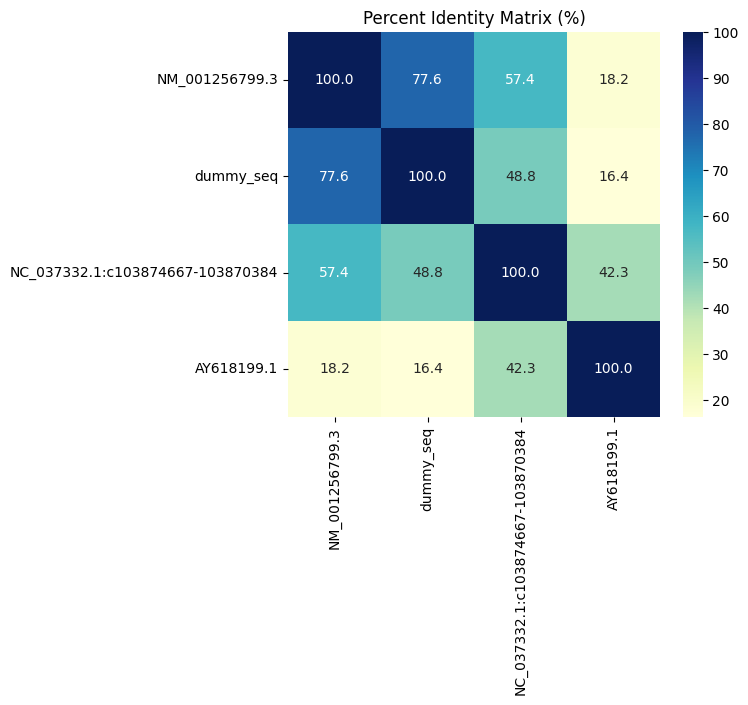

In [49]:
# Replace these with your FASTA file paths
seq_files = [
    "/content/drive/MyDrive/DATASET/sequence homo sapiens.fasta",
    "/content/drive/MyDrive/sequence bos taurus(cow).fasta",
    "/content/drive/MyDrive/sequence mouse.fasta"
]
# Merge into a single input FASTA for MSA
merged_fasta = "merged_sequences.fasta"
with open(merged_fasta, "w") as out_handle:
    for f in seq_files:
        for record in SeqIO.parse(f, "fasta"):
            SeqIO.write(record, out_handle, "fasta")
print(f"Sequences merged into {merged_fasta}")
# STEP 2: Run MSA
aligned_file = "msa_output.fasta"
# Requires Clustal Omega installed in system or Colab (apt install clustalo)
clustalomega_cline = ClustalOmegaCommandline(
    infile=merged_fasta, outfile=aligned_file, verbose=True, auto=True, force=True
)
print(" Running Clustal Omega...")
clustalomega_cline()
print(f" Alignment saved to {aligned_file}")
# STEP 3: Read Alignment
alignment = AlignIO.read(aligned_file, "fasta")
print(f"\nMSA contains {len(alignment)} sequences, length {alignment.get_alignment_length()}")
# Print alignment (nicely formatted)
print("\n--- Multiple Sequence Alignment ---")
for record in alignment:
    print(f"{record.id:<15} {record.seq}")
# STEP 4: Percent Identity Heatmap
def percent_identity(seq1, seq2):
    matches = sum(a == b for a, b in zip(seq1, seq2) if a != "-" and b != "-")
    length = min(len(seq1.replace("-", "")), len(seq2.replace("-", "")))
    return (matches / length) * 100 if length > 0 else 0
ids = [rec.id for rec in alignment]
n = len(ids)
matrix = [[0]*n for _ in range(n)]
for i in range(n):
    for j in range(n):
        matrix[i][j] = percent_identity(alignment[i].seq, alignment[j].seq)
plt.figure(figsize=(6,5))
sns.heatmap(matrix, annot=True, xticklabels=ids, yticklabels=ids, cmap="YlGnBu", fmt=".1f")
plt.title("Percent Identity Matrix (%)")
plt.show()


Pairwise Alignment: NM_001256799.3 vs NC_037332.1:c103874667-103870384
G-TC-C-G-----GA----T--G-C---T-GC-G---C--CTGC-G--GT---AG--A---GC--GGCCG-------CCAT----G---T-----T-G-CA--ACC-----GGGA--AGGAA---A-----------TG-----------------------A-ATG---G-GC--AGC-C---G--TT--AGG------A--AAGC--C-TGC-----CG--G-T-G---A------CT-------A---------A----C-----------------C--C------T------------GC---GC--TC-------C---T------GCC--T--C-G-AT----G-G----G-TGG--A-G-TCG-------CG--TG--T---GG-C-GGGG---A----AGT-CAG-G---TGG---AG------C--G--------A--G----GC--TAGC---T----G---GC-C--------C--GA-T----T--TC-T-CC----------------------TC-----C-G-G----G---TG-A--------T-G----C-T--T-T----------TCC---T--------------A---G-----------A---TT--A-----TT-C------T-C--------T----------G----------AT----T--T---G-----G----TC--------------G---T-------AT----TG---GG------C--G-CC-------------T-G---GT-C----A-C---C---------AGGG--C------------TGC-------------T--------T--T-T-----AACTC---------TG--G----T----A--AAG----TG---GA--T-------A----T--T------G--

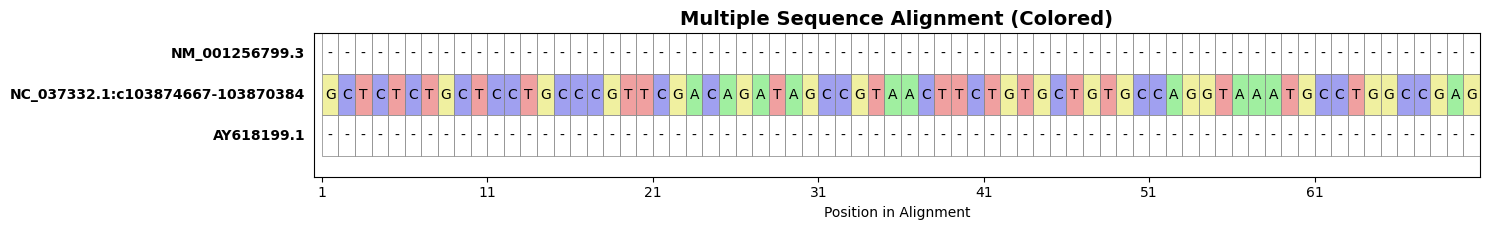

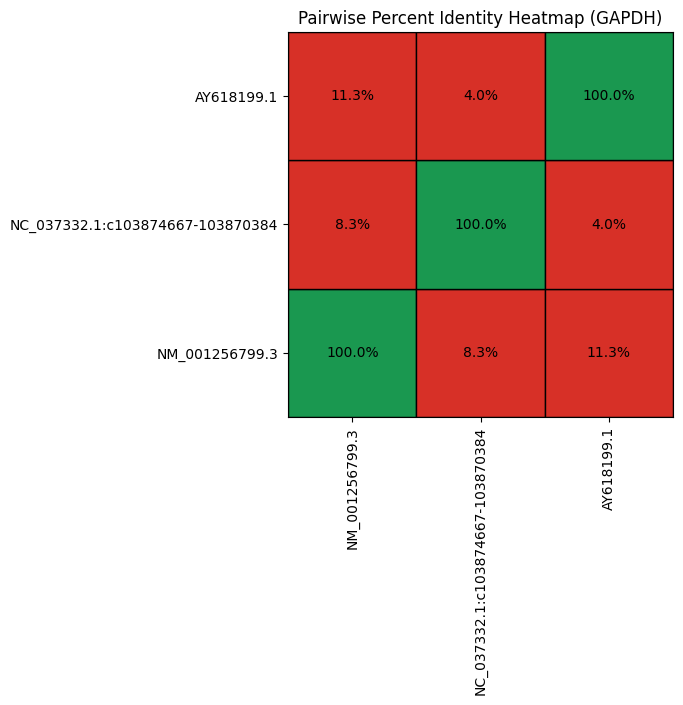

In [53]:
# INPUT: Multiple FASTA FILES
seq1 = next(SeqIO.parse("/content/drive/MyDrive/DATASET/sequence homo sapiens.fasta", "fasta"))  # Homo sapiens
seq2 = next(SeqIO.parse("/content/drive/MyDrive/sequence bos taurus(cow).fasta", "fasta"))        # Bos taurus
seq3 = next(SeqIO.parse("/content/drive/MyDrive/sequence mouse.fasta", "fasta"))                  # Mus musculus
records = [seq1, seq2, seq3]
# 1. Pairwise Alignment Visualization
def visualize_pairwise_alignment(seq1: SeqRecord, seq2: SeqRecord):
    alignments = pairwise2.align.globalxx(seq1.seq, seq2.seq)
    best_alignment = alignments[0]
    aligned_seq1, aligned_seq2, score, start, end = best_alignment
    match_line = ''.join(['|' if a == b else ' ' for a, b in zip(aligned_seq1, aligned_seq2)])
    print(f"\nPairwise Alignment: {seq1.id} vs {seq2.id}")
    print(aligned_seq1)
    print(match_line)
    print(aligned_seq2)
    print(f"Score: {score}\n")
# Run pairwise alignment for all pairs
visualize_pairwise_alignment(seq1, seq2)
visualize_pairwise_alignment(seq1, seq3)
visualize_pairwise_alignment(seq2, seq3)
# 2. Multiple Sequence Alignment (MSA) using Clustal Omega
print("\n--- Running Multiple Sequence Alignment with Clustal Omega ---")
input_fasta = "/tmp/msa_input.fasta"
aligned_fasta = "/tmp/msa_aligned.fasta"
SeqIO.write(records, input_fasta, "fasta")
# Define and run Clustal Omega
clustal_command = ClustalOmegaCommandline(
    infile=input_fasta,
    outfile=aligned_fasta,
    force=True,
    auto=True
)
# Run the command
subprocess.run(str(clustal_command), shell=True, check=True)
# Load alignment result
alignment = AlignIO.read(aligned_fasta, "fasta")
print(f"MSA completed. Alignment length: {alignment.get_alignment_length()} positions.")
# 3. Colored MSA Plot
def plot_colored_msa(alignment: MultipleSeqAlignment, start: int = 0, end: int = 70):
    """Creates a colored plot for all nucleotide sequences in an MSA."""
    color_scheme = {
        'A': '#A0EFA0',  # Light Green
        'T': '#F0A0A0',  # Light Red
        'G': '#F0F0A0',  # Light Yellow
        'C': '#A0A0F0',  # Light Blue
        '-': '#FFFFFF',  # White for gaps
    }
    end = min(end, alignment.get_alignment_length())
    aln_slice = alignment[:, start:end]
    num_seqs = len(aln_slice)
    block_len = aln_slice.get_alignment_length()
    fig, ax = plt.subplots(figsize=(15, num_seqs * 0.8))
    for i, record in enumerate(aln_slice):
        y_pos = num_seqs - 1 - i
        ax.text(-1, y_pos + 0.5, record.id, ha='right', va='center',
                fontsize=10, fontweight='bold')
        for j, nucleotide in enumerate(record.seq):
            color = color_scheme.get(nucleotide.upper(), '#C0C0C0')
            rect = Rectangle((j, y_pos), 1, 1, facecolor=color,
                             edgecolor='gray', linewidth=0.5)
            ax.add_patch(rect)
            ax.text(j + 0.5, y_pos + 0.5, nucleotide,
                    ha='center', va='center', fontsize=10)
    ax.set_xlim(-0.5, block_len)
    ax.set_ylim(-0.5, num_seqs)
    ax.set_yticks([])
    ax.set_xticks(range(0, block_len, 10))
    ax.set_xticklabels(range(start + 1, end + 1, 10))
    ax.set_xlabel("Position in Alignment")
    ax.set_title("Multiple Sequence Alignment (Colored)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
print("\n--- Generating Final MSA Plot ---")
plot_colored_msa(alignment)
# 4. Percent Identity Heatmap
def visualize_percent_identity_multibox(seqs):
    n = len(seqs)
    pid_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matches = sum(a == b for a, b in zip(str(seqs[i].seq), str(seqs[j].seq)))
            length = max(len(seqs[i].seq), len(seqs[j].seq))
            pid_matrix[i, j] = matches / length * 100
    bins = [0, 20, 40, 60, 80, 100]
    colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#1a9850']
    fig, ax = plt.subplots(figsize=(6, 5))
    for i in range(n):
        for j in range(n):
            val = pid_matrix[i, j]
            color_idx = np.digitize(val, bins) - 1
            color_idx = min(color_idx, len(colors) - 1)
            rect = plt.Rectangle((j, n - i - 1), 1, 1,
                                 facecolor=colors[color_idx], edgecolor='black')
            ax.add_patch(rect)
            ax.text(j + 0.5, n - i - 0.5, f"{val:.1f}%",
                    ha='center', va='center', color='black', fontsize=10)
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_xticks(np.arange(n) + 0.5)
    ax.set_yticks(np.arange(n) + 0.5)
    ax.set_xticklabels([s.id for s in seqs], rotation=90)
    ax.set_yticklabels([s.id for s in seqs][::-1])
    ax.set_title("Pairwise Percent Identity Heatmap (GAPDH)")
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.show()
visualize_percent_identity_multibox(records)

In [43]:
fasta_files = [
    "/content/drive/MyDrive/DATASET/sequence homo sapiens.fasta",
    "/content/drive/MyDrive/sequence bos taurus(cow).fasta",
    "/content/drive/MyDrive/sequence mouse.fasta",
]
# Use SeqIO.parse to handle multiple sequences per file
records = []
for f in fasta_files:
    records.extend(list(SeqIO.parse(f, "fasta")))
print(f"Total sequences loaded: {len(records)}")
# FUNCTION: ORF DETECTION
def find_orfs(sequence, min_length=100):
    """Find ORFs in a sequence."""
    seq = sequence.upper()
    stop_codons = ["TAA", "TAG", "TGA"]
    start_codon = "ATG"
    orfs = []
    # Forward strand
    for frame in range(3):
        start = None
        for i in range(frame, len(seq)-2, 3):
            codon = seq[i:i+3]
            if codon == start_codon and start is None:
                start = i
            if codon in stop_codons and start is not None:
                end = i + 3
                if end - start >= min_length:
                    orfs.append((start, end, frame, "+"))
                start = None
    # Reverse strand
    rev_seq = str(Seq(seq).reverse_complement())
    for frame in range(3):
        start = None
        for i in range(frame, len(rev_seq)-2, 3):
            codon = rev_seq[i:i+3]
            if codon == start_codon and start is None:
                start = i
            if codon in stop_codons and start is not None:
                end = i + 3
                if end - start >= min_length:
                    # Convert coordinates to original sequence
                    orfs.append((len(seq)-end, len(seq)-start, frame, "-"))
                start = None
    return orfs
# FUNCTION: MOTIF SEARCH
def find_motifs(sequence):
    """Search for known motifs in sequence."""
    motifs = {
        "TATA_box": "TATA[AT]A[AT][AG]",
        "Shine_Dalgarno": "AGGAGG",
        "Promoter": "TTGACA.{15,19}TATAAT",
        "Terminator": "A{5,}"  # Example: poly-A tail
    }
    results = {}
    for name, pattern in motifs.items():
        matches = [(m.start(), m.end(), m.group()) for m in re.finditer(pattern, sequence)]
        results[name] = matches
    return results
# FUNCTION: VISUALIZE FEATURES
def visualize_features(record, orfs, motifs, output_dir="plots"):
    """Visualize ORFs and motifs along the sequence."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    fig, ax = plt.subplots(figsize=(12, 2))
    seq_len = len(record.seq)
    # Plot ORFs
    for start, end, frame, strand in orfs:
        color = "blue" if strand=="+" else "purple"
        ax.plot([start, end], [1, 1], color=color, linewidth=5, alpha=0.6)
    # Plot motifs
    colors = {"TATA_box":"red", "Shine_Dalgarno":"green", "Promoter":"orange", "Terminator":"brown"}
    plotted_labels = set()
    for motif, locations in motifs.items():
        for (s, e, _) in locations:
            label = motif if motif not in plotted_labels else "_nolegend_"
            ax.plot([s, e], [1.2, 1.2], color=colors[motif], linewidth=4, label=label)
            plotted_labels.add(motif)
    ax.set_xlim(0, seq_len)
    ax.set_ylim(0.8, 1.5)
    ax.set_xlabel("Genome Position (bp)")
    ax.set_yticks([])
    ax.legend(loc="upper right")
    plt.title(f"Genome Annotation for {record.id}")
    # Save plot
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{record.id}_annotation.png")
    plt.close()
# RUN PIPELINE FOR EACH SEQUENCE
for rec in records:
    print(f"\n===== {rec.id} =====")
    # ORF detection
    orfs = find_orfs(str(rec.seq))
    print("Detected ORFs (first 5):")
    for start, end, frame, strand in orfs[:5]:
        print(f"Start: {start}, End: {end}, Frame: {frame}, Strand: {strand}, Length: {end-start} bp")
    # Motif search
    motifs = find_motifs(str(rec.seq))
    print("\nMotifs found:")
    for motif, locations in motifs.items():
        for (s, e, seq) in locations:
            print(f"{motif} at {s}-{e}: {seq}")
    # Visualization
    visualize_features(rec, orfs, motifs)
    print(f"Plot saved for {rec.id}")

Total sequences loaded: 4

===== NM_001256799.3 =====
Detected ORFs (first 5):
Start: 303, End: 1185, Frame: 0, Strand: +, Length: 882 bp
Start: 277, End: 583, Frame: 1, Strand: +, Length: 306 bp
Start: 712, End: 850, Frame: 1, Strand: +, Length: 138 bp
Start: 1117, End: 1282, Frame: 1, Strand: +, Length: 165 bp
Start: 69, End: 588, Frame: 0, Strand: -, Length: 519 bp

Motifs found:
Terminator at 925-930: AAAAA
Plot saved for NM_001256799.3

===== dummy_seq =====
Detected ORFs (first 5):

Motifs found:
Plot saved for dummy_seq

===== NC_037332.1:c103874667-103870384 =====
Detected ORFs (first 5):
Start: 57, End: 309, Frame: 0, Strand: +, Length: 252 bp
Start: 1266, End: 1389, Frame: 0, Strand: +, Length: 123 bp
Start: 1860, End: 1974, Frame: 0, Strand: +, Length: 114 bp
Start: 2085, End: 2202, Frame: 0, Strand: +, Length: 117 bp
Start: 2367, End: 2700, Frame: 0, Strand: +, Length: 333 bp

Motifs found:
Shine_Dalgarno at 543-549: AGGAGG
Shine_Dalgarno at 643-649: AGGAGG
Shine_Dalgarno a

/tmp/ipython-input-1600179046.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


Plot saved for NC_037332.1:c103874667-103870384

===== AY618199.1 =====
Detected ORFs (first 5):
Start: 32, End: 566, Frame: 2, Strand: +, Length: 534 bp
Start: 495, End: 633, Frame: 0, Strand: -, Length: 138 bp
Start: 319, End: 535, Frame: 2, Strand: -, Length: 216 bp

Motifs found:
Terminator at 70-75: AAAAA
Terminator at 393-398: AAAAA
Plot saved for AY618199.1


In [39]:
# SET EMAIL (NCBI requires this)
Entrez.email = "vashubelwal10@gmail.com"  # fix typo in your email
# FETCH BY ACCESSION NUMBER
accessions = ["NM_002046.7", "NM_001256799.3"]  # GAPDH human transcripts
handle = Entrez.efetch(db="nucleotide", id=",".join(accessions), rettype="fasta", retmode="text")
records = list(SeqIO.parse(handle, "fasta"))
handle.close()
print(f"Fetched {len(records)} sequences.")
# SEARCH NCBI (GAPDH human)
search_term = "GAPDH[Gene] AND Homo sapiens[Organism]"
handle = Entrez.esearch(db="nucleotide", term=search_term, retmax=5)
record = Entrez.read(handle)
handle.close()
print("Search results (IDs):", record["IdList"])
# PERFORM BLAST SEARCH
print("\nRunning BLAST for first accession...")
seq_to_blast = records[0].seq
result_handle = NCBIWWW.qblast("blastn", "nt", seq_to_blast)
# Save result locally
with open("blast_result.xml", "w") as out_handle:
    out_handle.write(result_handle.read())
result_handle.close()
# PARSE BLAST RESULTS
with open("blast_result.xml") as result_handle:
    blast_record = NCBIXML.read(result_handle)
print(f"\nQuery: {blast_record.query}")
print(f"Number of hits: {len(blast_record.alignments)}")
# First hit details
if blast_record.alignments:
    first_hit = blast_record.alignments[0]
    print(f"Hit ID: {first_hit.hit_id}")
    print(f"Hit definition: {first_hit.hit_def}")
    print(f"Alignment length: {first_hit.length}")
# FETCH FROM UNIPROT (GAPDH protein)
uniprot_id = "P04406"  # GAPDH human
url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"  # updated endpoint
response = requests.get(url)
if response.ok:
    fasta_data = response.text
    print("\nUniProt FASTA Header:")
    print(fasta_data.splitlines()[0])
else:
    print("Failed to fetch from UniProt:", response.status_code)

Fetched 2 sequences.
Search results (IDs): ['2194973269', '568815586', '1676440496', '1676318038', '1675171238']

Running BLAST for first accession...

Query: No definition line
Number of hits: 50
Hit ID: gi|1519316078|ref|NM_002046.7|
Hit definition: Homo sapiens glyceraldehyde-3-phosphate dehydrogenase (GAPDH), transcript variant 1, mRNA
Alignment length: 1285

UniProt FASTA Header:
>sp|P04406|G3P_HUMAN Glyceraldehyde-3-phosphate dehydrogenase OS=Homo sapiens OX=9606 GN=GAPDH PE=1 SV=3
